# Naive neural network

In [29]:
# Handling paths for importing code
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))

from Code.utilities import cross_entropy_loss_method, accuracy_func_method
from Code.descent_methods import SGD_adam
from Code.data_handling import load_MNIST_28, append_run_to_file, load_run_from_file
from Code.softmax_regression import softmax
from Code.neural_network import _beta_init, get_neural_network_model
from Code.plot import plot_faulty_predictions, plot_confusion_matrix, plot_grid_search_result, plot_some_imgs, plot_test_results

from jax import jit, nn, grad
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set the default font size for text elements (e.g., titles, labels)
import matplotlib as mpl
mpl.rcParams['font.size'] = 16
mpl.rcParams["axes.labelsize"] = 14
mpl.rcParams["axes.titlesize"] = 16
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['font.family'] = 'sans-serif'
plt.rcParams['xtick.labelsize']=12
plt.rcParams['ytick.labelsize']=12

### Training the neural network

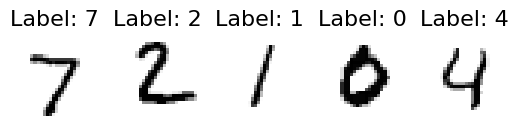

In [6]:
# download MNIST dataset
X_train, y_train, X_test, y_test = load_MNIST_28(flatten_images=True)

# Display some images
plot_some_imgs(X_test, y_test)

In [40]:
def single_run(X_train, X_test, y_train, y_test, 
               lr, lam, hidden_layer_num, node_per_hidden, 
               hidden_activation, output_activation=softmax,
               epochs=300, batch_size=32, plot_or_not=False,
               loss_func_and_name=(cross_entropy_loss_method, "CE"), #(MSELoss_method, "MSE")
               test_func_and_name=(cross_entropy_loss_method, "CE"), 
               result_filepath=None, store_params=False, intermediate_epochs=None):    
    """
    Performs a training with the given parameters

    Returns result, including the final accuracy scores
    """

    # Initialise beta and create the model
    layer_list = [X_train.shape[1]] + [node_per_hidden]*hidden_layer_num + [y_train.shape[1]]
    beta0 = _beta_init(layer_list)
    model = jit(get_neural_network_model(hidden_layer_num,activation=hidden_activation,
                                         output_activation=output_activation))

    # Create gradient from loss function. Also get the accuracy function
    loss_func = jit(loss_func_and_name[0](model=model, lam=lam))   
    loss_grad = jit(grad(loss_func))
    accuracy_func = jit(accuracy_func_method(model))

    # (usually MSE) loss function for evaluation
    if plot_or_not:
        test_func = jit(test_func_and_name[0](model))
    else:
        test_func = None

    # Perform training. We use adam, add the test index
    result = SGD_adam(X_train, y_train, X_test, y_test, 
                      grad_method=loss_grad,beta0=beta0, 
                      n_epochs=epochs, batch_size=batch_size,
                      test_loss_func= test_func, lr=lr, 
                      intermediate_epochs=intermediate_epochs)

    # Plot if wanted ...
    if plot_or_not:
        plot_test_results(result["test_loss_list"], result["train_loss_list"], ylabel=test_func_and_name[1])

    # Add accuracy scores
    result["test_accuracy"]  = float(accuracy_func(result["beta_final"], X_test, y_test))
    result["train_accuracy"] = float(accuracy_func(result["beta_final"], X_train, y_train))
    # Also store the model for potential later use
    result["model"] = model

    # Store the result to given file
    if result_filepath:

        _dict_to_store =  { "lr"                : lr, 
                            "lam"               : lam,
                            "batch_size"        : batch_size,
                            "hidden_layer_num"  : hidden_layer_num, 
                            "node_per_hidden"   : node_per_hidden, 
                            "hidden_activation" : hidden_activation.__name__,
                            "output_activation" : output_activation.__name__,
                            "loss_function"     : loss_func_and_name[1],
                            "train_num"         : y_train.shape[0],
                            "test_num"          : y_test.shape[0]
                          }
        if store_params:
            _dict_to_store["beta_final"] = {key: value.tolist() for key, value in result["beta_final"].items()}

        # Possibility of storing run with fewer epochs
        if intermediate_epochs is not None:
            for ie, be in zip(intermediate_epochs, result["beta_intermediate"]):
                append_run_to_file(result_filepath, {"test_accuracy"     : float(accuracy_func(be, X_test, y_test)), 
                                                     "train_accuracy"    : float(accuracy_func(be, X_train, y_train)),
                                                     "epochs"            : ie,
                                                     **_dict_to_store})

        append_run_to_file(result_filepath, {"test_accuracy"     : result["test_accuracy"], 
                                             "train_accuracy"    : result["train_accuracy"],
                                             "epochs"            : epochs,
                                             **_dict_to_store})

    return result

In [19]:
## A demonstration
epochs = 50
batch_size = 128 #4096 2048 # 128 # 1024
lr = 0.01 # 0.01
lam = 0
layers = 8
nodes = 1024
test_func_and_name = (accuracy_func_method, "Accuracy")
test_func_and_name = (cross_entropy_loss_method, "CE")
hidden_activation = nn.sigmoid
plot_or_not=False

result = single_run(X_train, X_test, y_train, y_test, 
                    lr=lr, lam=lam, hidden_layer_num=layers, node_per_hidden=nodes, hidden_activation=hidden_activation,
                    epochs=epochs, batch_size=batch_size, 
                    plot_or_not=plot_or_not, test_func_and_name=test_func_and_name,
                    result_filepath="test.json")

print("Accuracy test: ", result["test_accuracy"])
print("Accuracy train: ", result["train_accuracy"])

print(f"{test_func_and_name[1]} test: ", result["test_loss_list"][-1])
print(f"{test_func_and_name[1]} train: ", result["train_loss_list"][-1])

assert(False)

None


  2%|▏         | 1/50 [01:00<49:25, 60.52s/it]


KeyboardInterrupt: 

### Grid search

In [49]:
def run_experiment(layers=5, nodes=512, hidden_activation=nn.sigmoid, result_filepath="Results/neural_28_params.json"):
    batch_sizes           = [32, 64, 128, 256, 512]
    learning_rates        = [0.05, 0.02, 0.01, 0.005, 0.001]
    regularisation_params = [0, 0.00001, 0.001, 0.01]

    # We do one run with max epoch number, storing the intermediate as their own runs
    epoch_numbers = [2, 5, 8, 10, 15, 20, 35, 50]

    # Perform the #b*#l*#e experiments
    for r in regularisation_params:
        for b in batch_sizes:
            for l in learning_rates:

                print(f"Batch Size: {b}, Learning Rate: {l}, Regularisation: {r}")

                result = single_run(X_train, X_test, y_train, y_test, 
                                lr=l, 
                                lam=r, 
                                batch_size=b,
                                epochs=epoch_numbers[-1], 
                                intermediate_epochs=epoch_numbers[0:-1],
                                hidden_layer_num=layers, 
                                node_per_hidden=nodes, 
                                hidden_activation=hidden_activation,
                                plot_or_not=False, result_filepath=result_filepath)



# Grid search for one of the failed models
# run_experiment(4,512, nn.tanh)

#The best model so far has been:
# {
#   "test_accuracy": 0.982200026512146,
#   "train_accuracy": 0.9973000288009644,
#   "epochs": 10,
#   "lr": 0.01,
#   "lam": 0,
#   "batch_size": 128,
#   "hidden_layer_num": 2,
#   "node_per_hidden": 512,
#   "hidden_activation": "sigmoid",
#   "output_activation": "softmax",
#   "loss_function": "CE",
#   "train_num": 60000,
#   "test_num": 10000
# },

# We tune to push the limits further
run_experiment(2,512, nn.sigmoid, result_filepath="Results/neural_28_[512,512]_tuning.json")

Batch Size: 32, Learning Rate: 0.05, Regularisation: 0


100%|██████████| 50/50 [13:09<00:00, 15.78s/it]


Batch Size: 32, Learning Rate: 0.02, Regularisation: 0


100%|██████████| 50/50 [13:33<00:00, 16.27s/it]


Batch Size: 32, Learning Rate: 0.01, Regularisation: 0


100%|██████████| 50/50 [13:00<00:00, 15.61s/it]


Batch Size: 32, Learning Rate: 0.005, Regularisation: 0


 78%|███████▊  | 39/50 [17:03:25<4:48:39, 1574.49s/it]   


KeyboardInterrupt: 

### Architecture

In [55]:
epochs     = 10
lr         = 0.01
batch_size = 128
lam = 0
filepath = "Results/neural_28_relu.json"
hidden_activation=nn.relu

hidden_layer_nums = [0,1,2, 3, 4, 5, 6, 7, 8]
hidden_node_nums = [1024]#8, 16, 32, 64, 128, 256, 512, 1024] # 784 = size of input layer 
hidden_node_nums.reverse()

for layers in hidden_layer_nums:
    for nodes in hidden_node_nums:

        result = single_run(X_train, X_test, y_train, y_test, 
                        lr=lr, lam=lam, hidden_layer_num=layers, node_per_hidden=nodes, hidden_activation=hidden_activation,
                        epochs=epochs, batch_size=batch_size, 
                        plot_or_not=False, result_filepath=filepath)
        print(f"layers: {layers}, nodes: {nodes}, training_acc: {result['train_accuracy']}, test_acc: {result['test_accuracy']}")

100%|██████████| 10/10 [02:38<00:00, 15.81s/it]


layers: 2, nodes: 1024, training_acc: 0.09871665388345718, test_acc: 0.09800001978874207


100%|██████████| 10/10 [04:11<00:00, 25.13s/it]


layers: 3, nodes: 1024, training_acc: 0.09871665388345718, test_acc: 0.09800001978874207


100%|██████████| 10/10 [05:35<00:00, 33.51s/it]


layers: 4, nodes: 1024, training_acc: 0.09871665388345718, test_acc: 0.09800001978874207


100%|██████████| 10/10 [06:38<00:00, 39.88s/it]


layers: 5, nodes: 1024, training_acc: 0.09871665388345718, test_acc: 0.09800001978874207


100%|██████████| 10/10 [08:14<00:00, 49.41s/it]


layers: 6, nodes: 1024, training_acc: 0.09871665388345718, test_acc: 0.09800001978874207


100%|██████████| 10/10 [09:34<00:00, 57.48s/it]


layers: 7, nodes: 1024, training_acc: 0.09871665388345718, test_acc: 0.09800001978874207


100%|██████████| 10/10 [2:12:01<00:00, 792.12s/it]  


layers: 8, nodes: 1024, training_acc: 0.09871665388345718, test_acc: 0.09800001978874207


In [56]:
def plot_NN_grid_from_file(filepath):

    run_list = load_run_from_file(filepath)


    data = {
        "Node": [],
        "Layer": [],
        "Accuracy": [],
    }

    for run in run_list:
        
            data["Node"].append(run["node_per_hidden"])
            data["Layer"].append(run["hidden_layer_num"])
            data["Accuracy"].append(run["test_accuracy"])

    plot_grid_search_result(data)

# plot_NN_grid_from_file("Results/neural_28_relu.json")
# plot_NN_grid_from_file("Results/neural_28_sigmoid.json")
# plot_NN_grid_from_file("Results/neural_28_tanh.json")

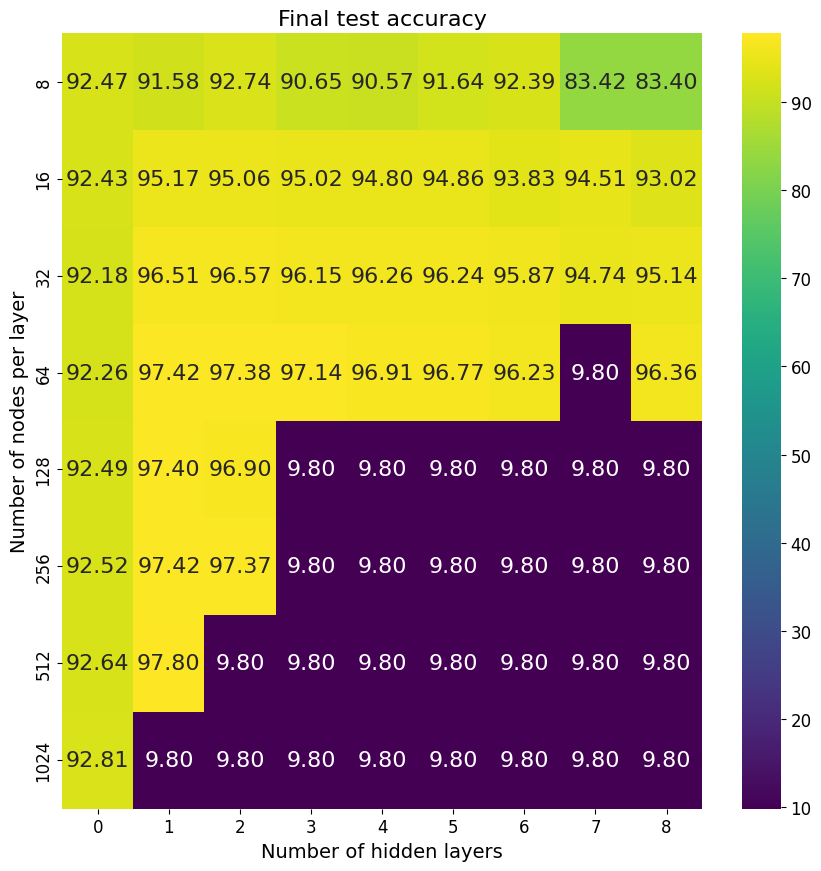

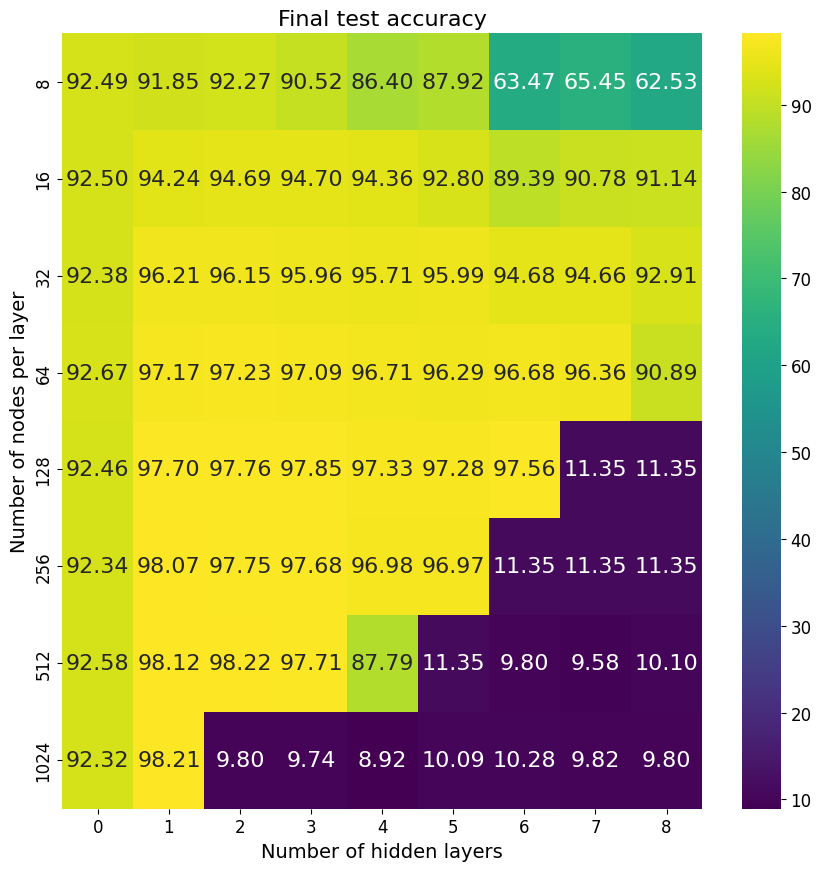

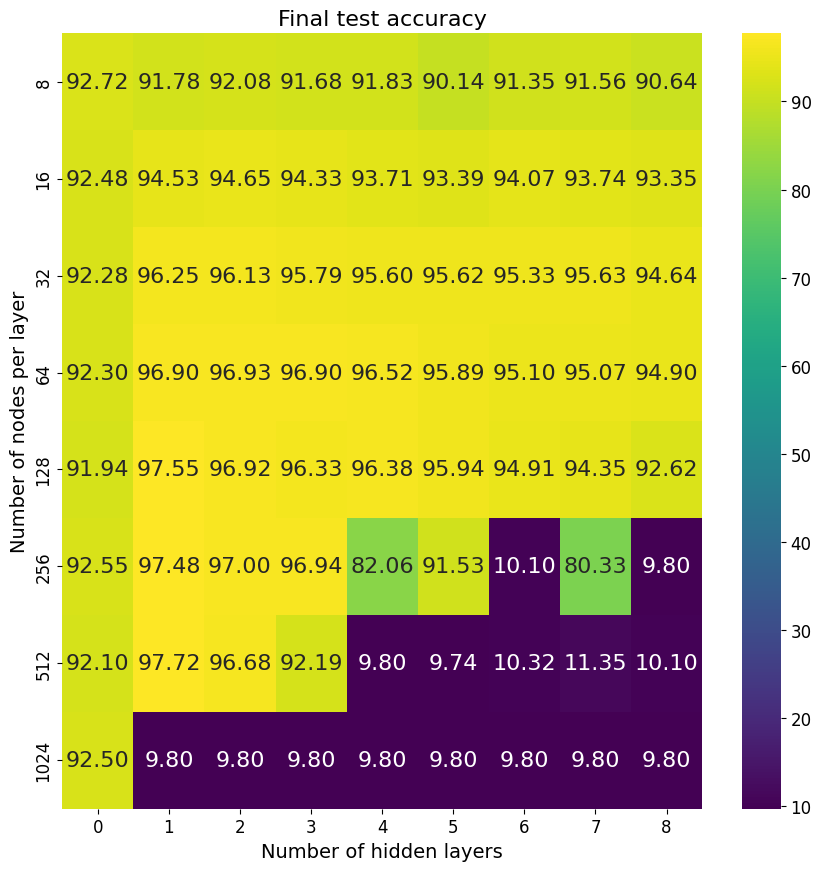

In [57]:
def plot_hidden_node_hidden_layer_grid(filepath):


    # Initialize lists for nodes, layers, and accuracies
    nodes_list = []
    layers_list = []
    accuracy_list = []

    # Load data
    data_list = load_run_from_file(filepath)

    # Iterate through the data_list
    for i, data in enumerate(data_list):
        # Extract relevant information
        nodes = data["node_per_hidden"]
        layers = data["hidden_layer_num"]
        accuracy = data["test_accuracy"]

        # Append to the lists
        nodes_list.append(nodes)
        layers_list.append(layers)
        accuracy_list.append(accuracy)

    # Get unique nodes and layers along with their original indices
    unique_nodes, node_indices = np.unique(nodes_list, return_inverse=True)
    unique_layers, layer_indices = np.unique(layers_list, return_inverse=True)

    # Create a matrix and fill with accuracies
    accuracy_matrix = np.empty((len(unique_nodes), len(unique_layers)))
    accuracy_matrix.fill(np.nan)

    for i, (node, layer, acc) in enumerate(zip(node_indices, layer_indices, accuracy_list)):
        accuracy_matrix[node, layer] = acc*100

    # Make the plot
    fig, ax = plt.subplots(figsize=(9, 9))
    sns.heatmap(accuracy_matrix, annot=True, ax=ax, cmap="viridis", cbar=True, fmt=".2f", )

    # Title
    ax.set_title("Final test accuracy")

    # Handle labels
    ax.set_xlabel("Number of hidden layers")
    ax.set_ylabel("Number of nodes per layer")

    ax.set_xticks(np.arange(len(unique_layers)) + 0.5)
    ax.set_yticks(np.arange(len(unique_nodes)) + 0.5)
    ax.set_xticklabels(unique_layers)
    ax.set_yticklabels(unique_nodes)

    plt.tight_layout()
    plt.show()

plot_hidden_node_hidden_layer_grid("Results/neural_28_relu.json")
plot_hidden_node_hidden_layer_grid("Results/neural_28_sigmoid.json")
plot_hidden_node_hidden_layer_grid("Results/neural_28_tanh.json")

### Final model evaluation

We make confusion matrix ...

100%|██████████| 10/10 [01:23<00:00,  8.36s/it]


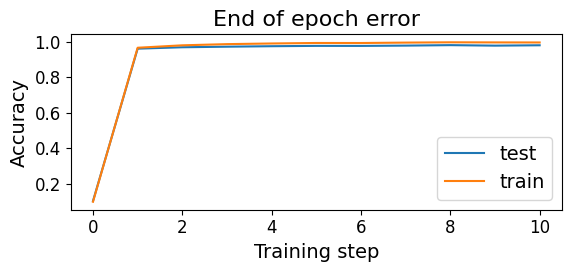

test:  0.9797000288963318
train:  0.9954500198364258
CE test:  0.9797
CE train:  0.99545


In [63]:
np.random.seed(42)

## A demonstration
epochs     = 10
batch_size = 128
lr         = 0.01
lam        = 0

layers = 2
nodes  = 512
hidden_activation=nn.sigmoid

result = single_run(X_train, X_test, y_train, y_test, 
                    lr=lr, 
                    lam=lam, 
                    hidden_layer_num=layers, 
                    node_per_hidden=nodes, 
                    hidden_activation=hidden_activation,
                    epochs=epochs, 
                    batch_size=batch_size, 
                    plot_or_not=True, 
                    test_func_and_name=(accuracy_func_method, "Accuracy"),
                    result_filepath="test.json")

print("test: ", result["test_accuracy"])
print("train: ", result["train_accuracy"])

print("CE test: ", result["test_loss_list"][-1])
print("CE train: ", result["train_loss_list"][-1])

model = result["model"]
beta = result["beta_final"]

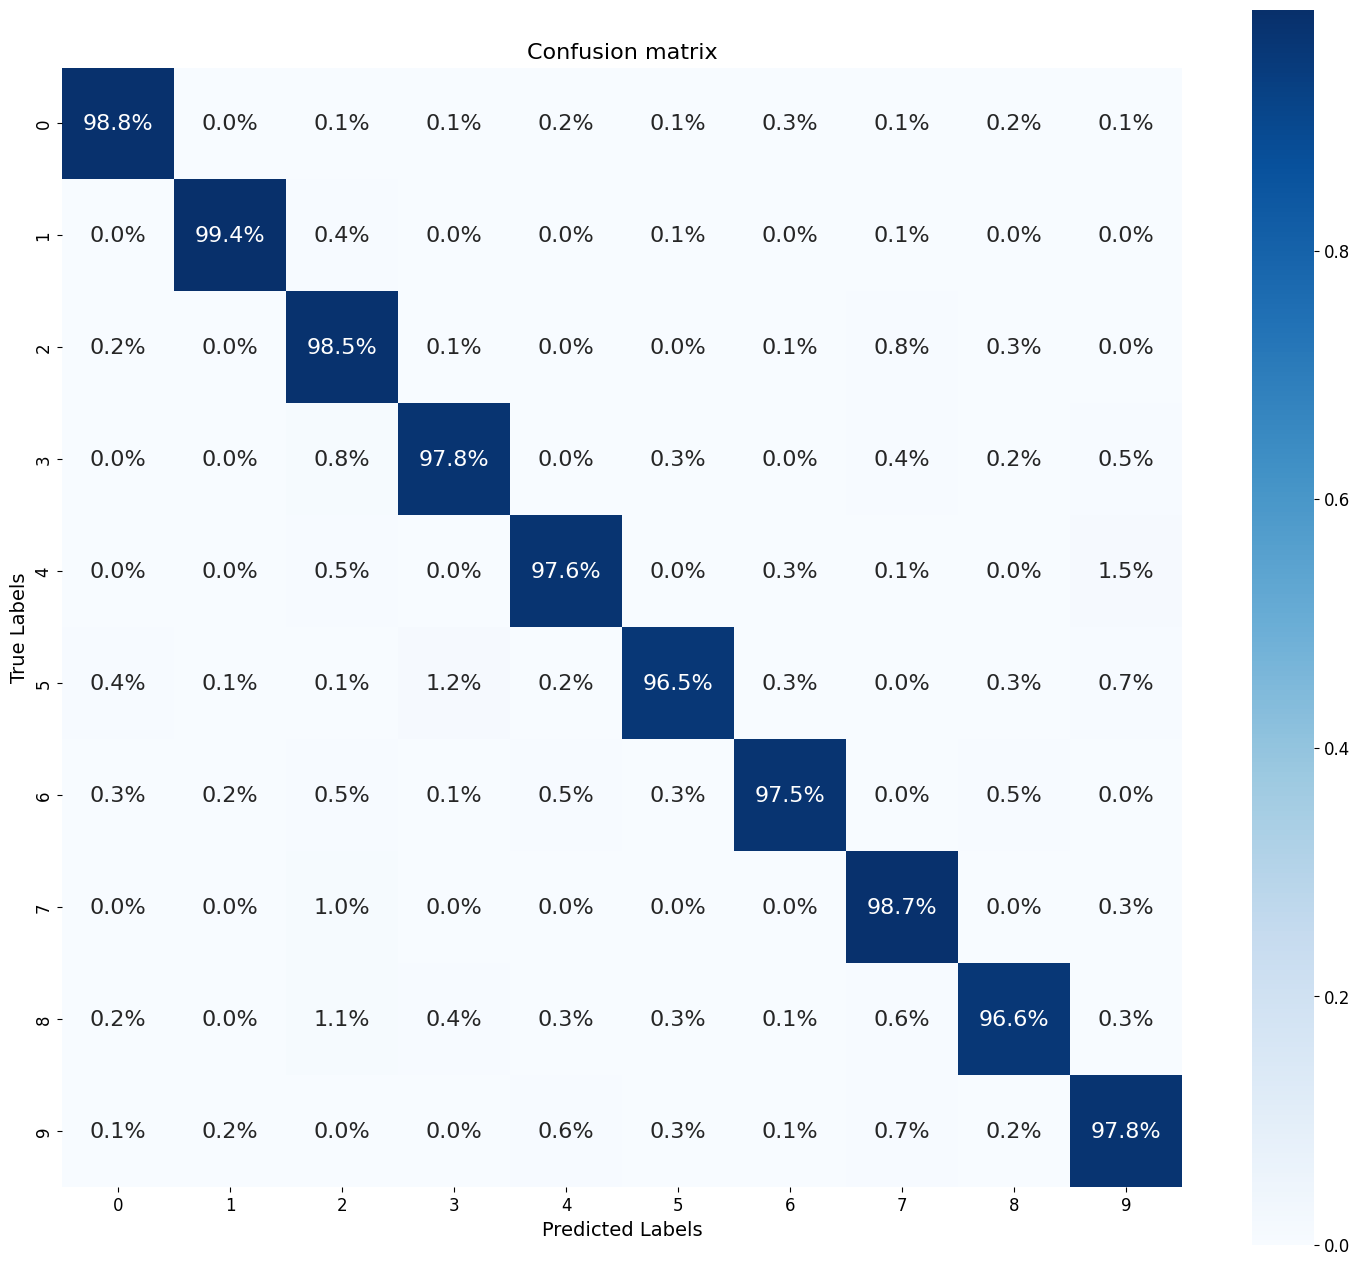

In [64]:
plot_confusion_matrix(X_test, y_test, model, beta, convert_to_percent=True)

Also want to see exactly where the model fails ...

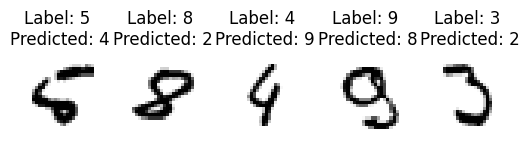

In [65]:
plot_faulty_predictions(X_test, y_test, model, beta)